# MosAIc 

## Einführung

Wir sind Henning Sanders, Jannik Wübbe und Fynn Ellinghaus aus der MosAIc-Gruppe des Modules Medienverarbeitung 21/22. In dem folgenden Dokument erhalten Sie einen detaillierten Einblick über unser Projekt. 
Es war unser Ziel eine Software zu erstellen, die aus einer beliebigen Videodatei bzw. Bildergalerie automatisiert ein Mosaik aus einer Bildvorlage erstellen kann. 
Unsere Idee war es eine Videodatei wie z.B. eine Computerspielaufnahme oder auch eine Aufnahme einer Festivität in die Software einlesen zu können. Diese kreiert aus dieser mittels Frames (Standbilder), eine Bildbibliothekt. Diese kann im nachfolgenden genutzt werden durch ein eingelesenes Bild welches als Schablone dient, ein Mosaik automatisiert zu erstellen.
Wir hoffen Sie werden freude beim lesen haben.

## Ersten Schritte

### Ein Anfang muss gemacht werden

In den ersten Schritten war unsere Idee erstmal anzufangen und die Grundfunktionen des Programmes zu erstellen. Hierzu haben wir zunächst eine Funktion erstellt, die es uns ermöglicht Bilder in Python zu importerien. Weil in Python der Farbwert mit BGR (blue/green/red) angegeben wird und wir verhindern wollten, dass wir dadurch fehler einbauen, haben wir eine Konvertierung eingebaut, die BGR auf RGB (red/green/blue) umschreibt. 

Unsere nächste Intention war es, ein Bild quadratisch zuzuschneiden. Weil ein Pixel ebenfalls quadratisch ist und die von uns genutzten Bilder im 16:9 Format waren, wollten wir diese zuschneiden, um es später einfacher zu haben, die Pixel durch die Bilder zu ersetzten.
Als erstes haben wir mit festen breiten (width) und höhen (hight) Werten gearbeitet. Mit der mathplotlib haben wir uns eine Ausgabe erschaffen, damit wir direkt die Resultate sehen können. Weil uns aber bewusst war, dass wir nicht nur mit 1920x1080 Bildern arbeiten werden, haben wir die Funktion verallgemeinert.
Das Bild wird im letzten Schritt testweise quadratisch zugeschnitten und in 256x256 ausgegeben und angezeigt.

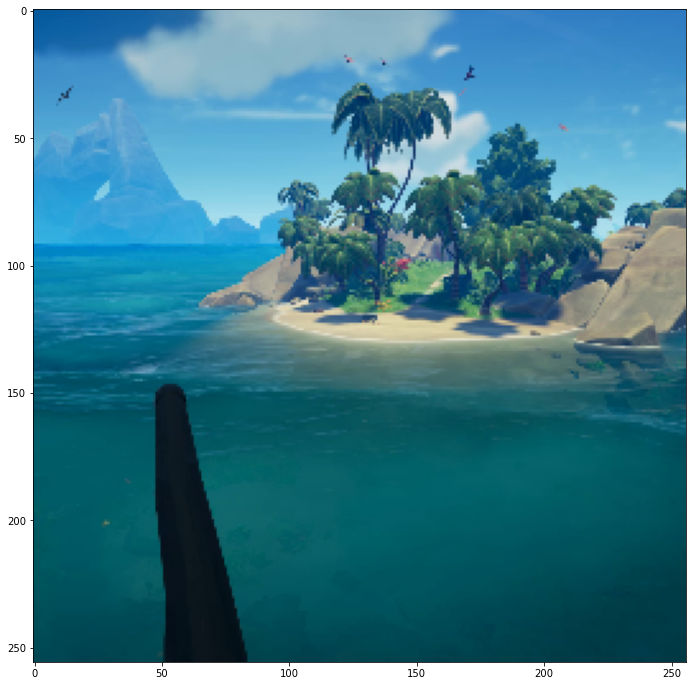

In [1]:
import cv2
import matplotlib.pyplot as plt
import math
import os
import numpy as np
import matplotlib

matplotlib.rcParams['figure.figsize'] = [12, 12]
matplotlib.rcParams['figure.dpi'] = 72

#Bild importieren mit RGB Konvertierung
def rgbImport(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

#Beliebiges Bild quadratisch zuschneiden
def quadsize(img):

    height, width, channels = img.shape

    if width > height :
        wStart = int((width - height)/2)
        wEnd = wStart + height
        cropped_image = img[:, wStart:wEnd]
    else :
        hStart = int((height - width)/2)
        hEnd = hStart + width
        cropped_image = img[hStart:hEnd, :]
        
    
    return cv2.resize(cropped_image,(256,256))

img = rgbImport("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/174.png")
quadImg = quadsize(img)
        
plt.imshow(quadImg)

Der folgende Ansatz war es, dass das Bild Verpixelt wird um eine kleinere Dateildichte zu erreichen. Hierzu wurde die dynamische Verpixelung genutzt. Mit dieser Methode wird jedes Bild welches eingelesenw ir dum den Faktor 12 komprimiert. Unsere Idee war es dadurch den Farbwert besser bestimmten zu können und Ressourcen zu sparen.

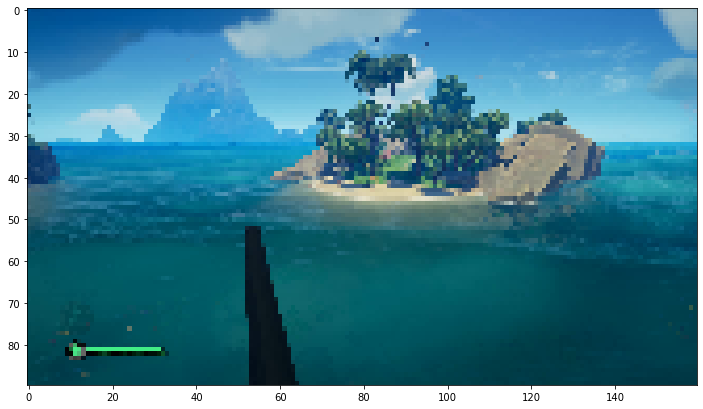

In [2]:
#Komprimierungsansatz mittels dynamischer Verpixelung
def destroyImgDyn(img):
    height, width, channels = img.shape
    img = cv2.resize(img,(int(width/12),int(height/12)))
    return img

toDestroyImg = rgbImport("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/174.png")
plt.imshow(destroyImgDyn(toDestroyImg))

Um es zu vereinfachen, haben wir eine fast gleiche Methode geschrieben, welche das Bild auf die feste Größe von 128x72 komprimiert. 

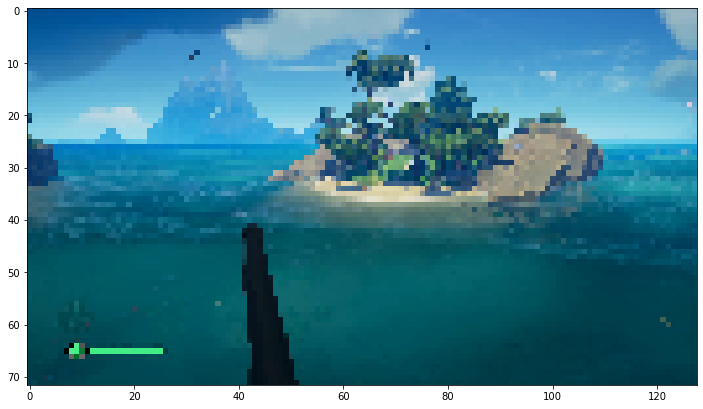

In [3]:
#Komprimierungsansatz auf feste Größe (TODO: auch Hochkanntbilder sollen unterstützt werden)
def destroyImgFix(img):
    height, width, channels = img.shape
    img = cv2.resize(img,(128,72))
    return img

plt.imshow(destroyImgFix(toDestroyImg))

Der nächste Schritt war es von einem Bild den durschschnittlichen Farbwert zu bestimmen. Dieses soll uns später die Möglichkeit geben Farbwerte zu vergleichen. 
Hierzu wurde die folgende Methode geschrieben, welche sich aber als Fehler herausstellte. Der Gedanke war, das Bild auf eine größe von 1x1 Pixel zu zuschneiden, um dadurch den mittleren Farbwert zu erhalten. Dies stellte sich aber als Fehlschlag heraus, weil das Bild auf den ersten Pixel zugeschnitten wurde und es dadruch einen verfälschten Wert für uns geliefert hat. So wurden beispielsweise Bereiche in einem Bild hell dargestellt, obwohl diese eigentlich dunkel sein müssten.
Diese Methode wurde durch die getColorValue Methode ersetzt.

In [4]:
#Methode, die den durschnittlichen Farbwert eines Bildes liefert
def getColorValueWRONG(img):
    img = cv2.resize(img, (1,1))
    return img[0][0]

getColorValueWRONG(img)

array([209, 201, 167], dtype=uint8)

In der getColorValue Methode nutzen wir den Median, also den mittleren Wert um den Farbwert zu bestimmen. 

In [5]:
#Methode, die den durschnittlichen Farbwert eines Bildes liefert
def getColorValue(img):
    return img.mean(axis=0).mean(axis=0)

getColorValue(img)

array([ 42.76270158, 114.94576003, 137.80174286])

Mit den vorhandenen Methoden ist es uns möglich die Farbwerte zu bestimmen und im nächsten Schritt sollen zwei Farbwerte miteinander verglichen werden können. Hierzu nutzen wir die Euklidische Distanz im dreidiminsionalen Raum:

$$d(p,q) = \sqrt{(q1 - p1)^2 + (q2 - p2)^2 + (q3 - p3)^2} = \sum \limits _{i=1} ^{n}(qi - pi)^2$$

Der Sinn dieser Methoden wird es sein, den Farbwert eines Pixels zu bestimmen und diesen mit dem mittleren Farbwert eines Bildes vergleichen zu können. Dies ermöglicht es uns ein Bild zu finden, welches dem Farbwert des Pixels am nächsten kommt um später diesen Pixel durch das Bild zu ersetzen. Wenn dies für jeden Pixel durchgeführt wird, sollte am Ende ein Mosaik entstehen, welches sehr ähnliche Farbwerte aufweist und das Schablonenbild sehr nah immitert.

In [6]:
#Euklidische Distanz berechen (Farbunterschied)
def getColorDifference(color1, color2):
    return math.sqrt((int(color1[0])- int(color2[0]))**2+(int(color1[1]) - int(color2[1]))**2+(int(color1[2])- int(color2[2]))**2)

getColorDifference(getColorValue(img),getColorValue(toDestroyImg))

0.0

Weil ein Mosaik nicht nur aus einem Bild sondern aus vielen besteht, haben wir uns ein Programm gesucht, welches uns aus einer Videodatei eine Bilderbibliothek erstellen kann. Dieses heißt ffmpeg und kann fast alle gängigen Videoformate lesen und bearbeiten. Es wird über die Eingabeaufforderung gestartet.
Mit den folgenden Parametern lesen wir die Videodatei und erhalten einzelne Bilder.

                ffmpeg -i video.mp4 -vf fps=1/5 bib/out%d.jpeg
        
ffmpeg startet das Programm. Danach wird der Dateipfad der Videodatei angegeben (in unserem Fall in dem Ordner des Programms selbst). Mit -vf wird dem Programm mitgeteilt, dass wir Videoframes haben wollen und mit den fps geben wir an, dass wir alle fünf Sekunden ein Frame (Bild) haben wollen. Zuletzt geben wir den Ausgabeordner (bib) an und den Namen sowie das Dateiformat (jpeg), den das Bild haben soll. Mit %d werden die Bilder automatisch durch nummeriert. 

Anfangs haben wir selbst aufgenommene Videodateien aus dem Videospiel "Hunt: Showdown" genutzt. Hier wird später noch näher drauf eingegangen. 

Mit der getAllImages Methode, werden alle Bilder aus der Bilderbibliothek in ein Array geladen. Uns wird zur bestätigung die länge des Arrays (Anzahl der Bilder) und ein Beispielbild ausgegeben.

240


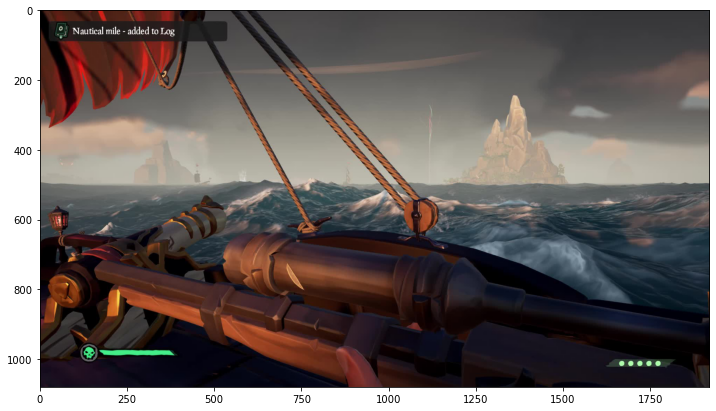

In [8]:
#Funktion, die Bilder importiert
def getAllImages(folderPath):
    images = []
    for filename in os.listdir(folderPath):
        img = rgbImport(os.path.join(folderPath, filename))
        if img is not None:
            images.append(img)
    return images
    
allImages = getAllImages("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/out")
print(len(allImages))
plt.imshow(allImages[0])

Jetzt werden mit cropAllImages alle Bilder zugeschnitten. Dies geschrieht mit der quadsize Methode vom Anfang.

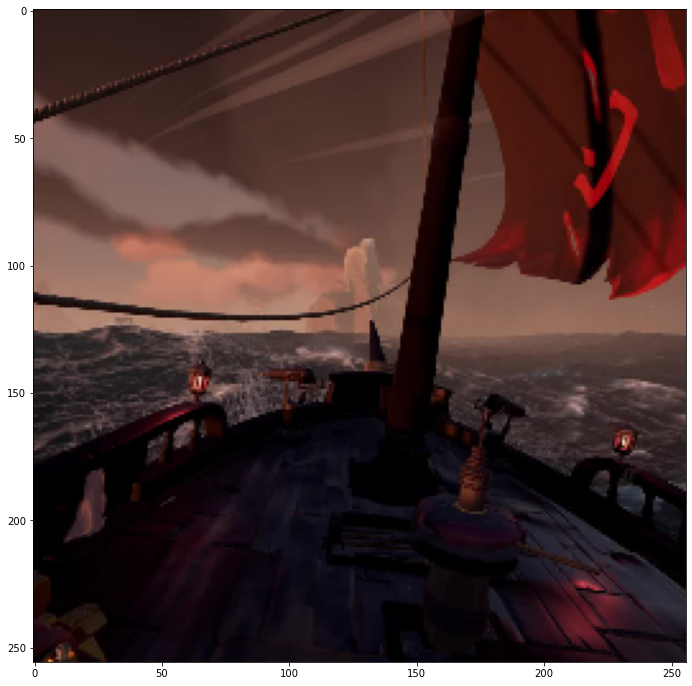

In [9]:
#Schneidet alle Bilder zu
def cropAllImages(allImages):
    allCroppedImages = []
    for img in allImages:
        allCroppedImages.append(quadsize(img))
    return allCroppedImages

plt.imshow(cropAllImages(allImages)[1])

Weiter werden alle Farbwerte der einzenen Bilder bestimmt und in dem allColorValues Array abgespeichert.

In [10]:
#Ermittelt die durchschnittlichen Farbwerte aller Bilder
def getAllColorValues(allImages):
    allColorValues = []
    for img in allImages:
        allColorValues.append(getColorValue(img))
    return allColorValues

getAllColorValues(allImages)[1]

array([65.83386526, 40.45110484, 37.80423756])

Es ist an der Zeit alles zusammen zu führen. In der createMosaic Methode wird zunächst mit dem originImg das Bild welches als Schablone dienen soll in mit der destroyImgFix in die gewünschte Verpixelung und größe gebracht.
Dann werden höhe, breite und die channel ausgelesen.
Nun wird das Bild zeilenweise durchlaufen und für jeden Pixel des ogriginImg (der Schablone) werden die Farbwerte mit denen in dem allColorValues Array verglichen um den Farbwert mit dem geringsten Abstand zu finden. Wenn der minimalste Abstand gefunden wurde, wird das Bild aus dem Array allCroppedImages an der Position des Farbwertes angehanden. Dies wird konkatenierend durchgeführt, biss das gesammte Bild durchlaufen wurde.

Der erste Versuch ist fehlgeschlagen, weil wir falsche Werte genutzt hatten und Bilder mit 1920x1080 aneinander zu hängen. Dies hat den RAM eines PC's in die Knie gezwungen, nachdem eine Dateigröße von 7,81GB erschaffen wurde und der Prozess noch nicht beendet war.
Nach diesem Fehler wurden kleiner Werte für die destroyImgFix Methode gewählt. 

Wie zuvor schon erwähnt nutzten wir zunächst Bilder des Videospiels "Hunt: Showdown". Nach vielen tests ist uns klar geworden, dass sich dieses Spiel nicht gut eignet, weil die Farbwerte des Spiels sich viel im braunen, dunkel grünen und sandfarbenden Farbbereich abspielt. Es ist schwirig helle Bereiche und Bildtiefe darzustellen. Aus diesem Grund haben wir uns vorgenommem zu einem anderen Spiel zu welchseln, welches ein weiteres Farbspektrum abdeckt. Es wurden noch weitere Bilder getestet wie z.B Hundebilder, Naturbilder und Gesichter. Uns ist schnell klar geworden, dass es einfacher ist Gesichter darzustellen, weil das menschliche Gehirn evolutionär darauf geeigt ist diese schnell zu erfassen.

In [11]:
#Erstellt das MosAIc
def createMosaic(originImg, allCroppedImages, allColorValues):
    originImg = destroyImgFix(originImg)
    height, width, channels = originImg.shape
    col = []
    for y in range(height):
        row = []
        for x in range(width):
            minDif = 500
            for i in range(len(allColorValues)):
                value = allColorValues[i]
                dif = getColorDifference(value, originImg[y,x])
                if dif < minDif:
                    minDif = dif
                    minDifPosition = i
            row.append(allCroppedImages[minDifPosition])
        col.append(np.concatenate(row, axis = 1))
    return cv2.cvtColor(np.concatenate(col, axis = 0), cv2.COLOR_BGR2RGB)
    
    #Henning: "Ich würde sagen, das sieht gut aus."

images = getAllImages("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/out")

mosaic = createMosaic(rgbImport("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/174.png"), cropAllImages(images), getAllColorValues(images))
cv2.imwrite("E:/Shadowplay/Sea of Thieves/ffmpeg-N-104475-g1728127e8c-win64-gpl/bin/output.jpeg", mosaic)
#plt.imshow(mosaic)
            
        
    


True

In [12]:
#Größter Farbwertunterschied
getColorDifference([255,255,255],[0,0,0])

441.6729559300637